# Text classification: OCR error

In [1]:
import warnings
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
from numba import NumbaDeprecationWarning, NumbaWarning
from numpy.random import RandomState
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from dpemu import runner
from dpemu.dataset_utils import load_newsgroups
from dpemu.filters.text import OCRError
from dpemu.ml_utils import reduce_dimensions_sparse
from dpemu.nodes.array import Array
from dpemu.pg_utils import load_ocr_error_params, normalize_ocr_error_params
from dpemu.plotting_utils import visualize_best_model_params, visualize_scores, visualize_classes, \
    print_results_by_model, visualize_confusion_matrices
from dpemu.utils import get_project_root

warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaWarning)

In [2]:
def get_data():
    data, labels, label_names, dataset_name = load_newsgroups("all", 10)
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2,
                                                                        random_state=RandomState(42))
    return train_data, test_data, train_labels, test_labels, label_names, dataset_name

In [3]:
def get_err_root_node():
    err_root_node = Array()
    err_root_node.addfilter(OCRError("normalized_params", "p"))
    return err_root_node


In [4]:
def get_err_params_list():
    p_steps = np.linspace(0, .98, num=8)
    params = load_ocr_error_params(f"{get_project_root()}/data/example_ocr_error_config.json")
    normalized_params = normalize_ocr_error_params(params)
    err_params_list = [{
        "p": p,
        "normalized_params": normalized_params
    } for p in p_steps]

    return err_params_list

In [5]:
class Preprocessor:
    def __init__(self):
        self.random_state = RandomState(0)

    def run(self, train_data, test_data, _):
        vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words="english")
        vectorized_train_data = vectorizer.fit_transform(train_data)
        vectorized_test_data = vectorizer.transform(test_data)

        reduced_test_data = reduce_dimensions_sparse(vectorized_test_data, self.random_state)

        return vectorized_train_data, vectorized_test_data, {"reduced_test_data": reduced_test_data}

In [6]:
class AbstractModel(ABC):

    def __init__(self):
        self.random_state = RandomState(42)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        predicted_test_labels = fitted_model.predict(test_data)
        cm = confusion_matrix(test_labels, predicted_test_labels)
        return {
            "confusion_matrix": cm,
            "predicted_test_labels": predicted_test_labels,
            "test_mean_accuracy": round(np.mean(predicted_test_labels == test_labels), 3),
            "train_mean_accuracy": fitted_model.score(train_data, train_labels),
        }


class MultinomialNBModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return MultinomialNB(params["alpha"]).fit(train_data, train_labels)


class LinearSVCModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return LinearSVC(C=params["C"], random_state=self.random_state).fit(train_data, train_labels)

In [7]:
def get_model_params_dict_list(train_labels, test_labels):
    alpha_steps = [10 ** i for i in range(-4, 1)]
    C_steps = [10 ** k for k in range(-3, 2)]
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": MultinomialNBModel,
            "params_list": [{"alpha": alpha, **model_params_base} for alpha in alpha_steps],
            "use_clean_train_data": False
        },
        {
            "model": MultinomialNBModel,
            "params_list": [{"alpha": alpha, **model_params_base} for alpha in alpha_steps],
            "use_clean_train_data": True
        },
        {
            "model": LinearSVCModel,
            "params_list": [{"C": C, **model_params_base} for C in C_steps],
            "use_clean_train_data": False
        },
        {
            "model": LinearSVCModel,
            "params_list": [{"C": C, **model_params_base} for C in C_steps],
            "use_clean_train_data": True
        },
    ]

In [8]:
def visualize(df, dataset_name, label_names, test_data):
    visualize_scores(
        df,
        score_names=["test_mean_accuracy", "train_mean_accuracy"],
        is_higher_score_better=[True, True],
        err_param_name="p",
        title=f"{dataset_name} classification scores with added error"
    )
    visualize_best_model_params(
        df,
        "MultinomialNB",
        model_params=["alpha"],
        score_names=["test_mean_accuracy"],
        is_higher_score_better=[True],
        err_param_name="p",
        title=f"Best parameters for {dataset_name} classification",
        y_log=True
    )
    visualize_best_model_params(
        df,
        "LinearSVC",
        model_params=["C"],
        score_names=["test_mean_accuracy"],
        is_higher_score_better=[True],
        err_param_name="p",
        title=f"Best parameters for {dataset_name} classification",
        y_log=True
    )
    visualize_classes(
        df,
        label_names,
        err_param_name="p",
        reduced_data_column="reduced_test_data",
        labels_column="test_labels",
        cmap="tab20",
        title=f"{dataset_name} test set (n={len(test_data)}) true classes with added error"
    )    
    visualize_confusion_matrices(
        df,
        label_names,
        score_name="test_mean_accuracy",
        is_higher_score_better=True,
        err_param_name="p",
        labels_col="test_labels",
        predictions_col="predicted_test_labels",
    )
    plt.show()

In [9]:
def main():
    train_data, test_data, train_labels, test_labels, label_names, dataset_name = get_data()

    df = runner.run(
        train_data=train_data,
        test_data=test_data,
        preproc=Preprocessor,
        preproc_params=None,
        err_root_node=get_err_root_node(),
        err_params_list=get_err_params_list(),
        model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    )

    print_results_by_model(df, dropped_columns=[
        "train_labels", "test_labels", "reduced_test_data", "confusion_matrix", "predicted_test_labels",
        "normalized_params"
    ])
    visualize(df, dataset_name, label_names, test_data)

Models LinearSVCClean and MultinomialNBClean have been trained with clean data and LinearSVC and MultinomialNB with erroneus data.

100%|██████████| 8/8 [07:27<00:00, 64.64s/it]
/home/thalvari/PycharmProjects/dpEmu/dpemu/plotting_utils.py:270: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 8))


LinearSVC #1
         C     p  test_mean_accuracy    time_err  time_mod   time_pre  train_mean_accuracy
0    0.001  0.00               0.720    9.515553  0.181865  17.161934             0.792343
1    0.010  0.00               0.809    9.515553  0.238347  17.161934             0.884620
2    0.100  0.00               0.842    9.515553  0.267581  17.161934             0.946658
3    1.000  0.00               0.846    9.515553  0.400847  17.161934             0.973005
4   10.000  0.00               0.835    9.515553  1.743023  17.161934             0.974043
5    0.001  0.14               0.645   48.582922  0.239222  18.228688             0.760286
6    0.010  0.14               0.751   48.582922  0.271246  18.228688             0.879948
7    0.100  0.14               0.799   48.582922  0.336668  18.228688             0.951979
8    1.000  0.14               0.798   48.582922  0.537449  18.228688             0.973783
9   10.000  0.14               0.789   48.582922  2.878400  18.228688        

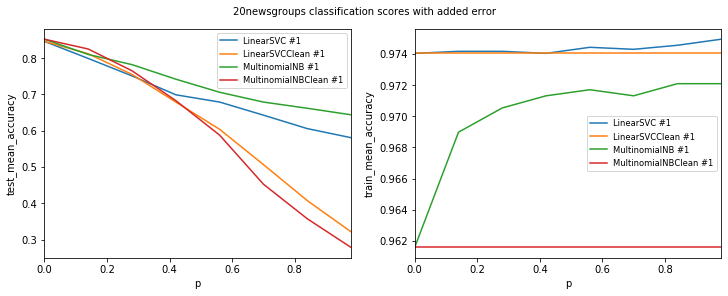

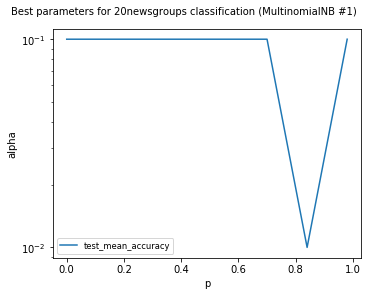

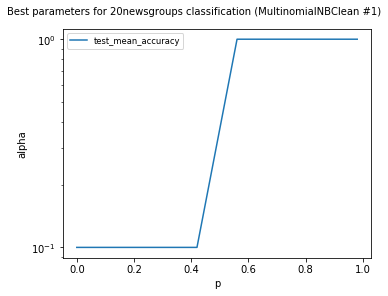

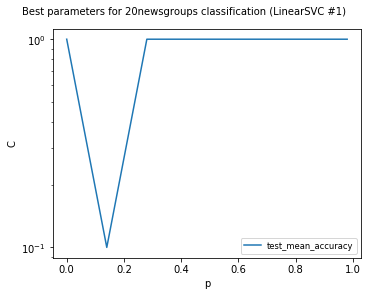

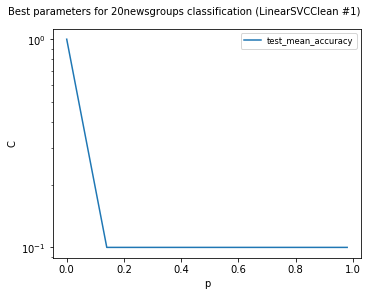

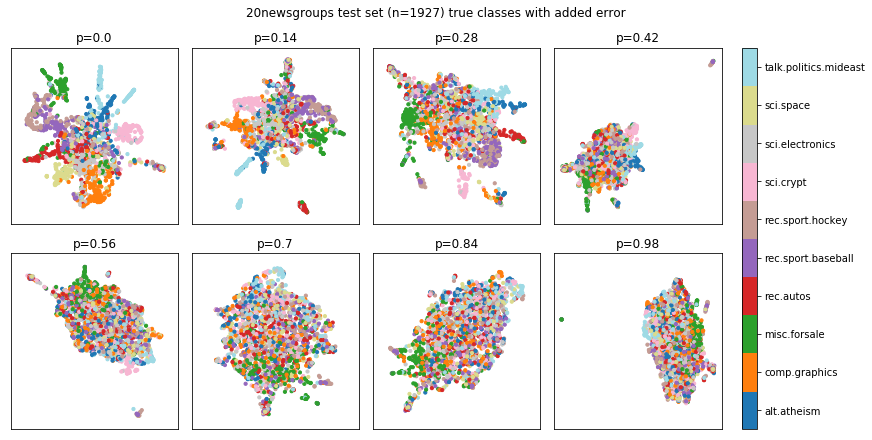

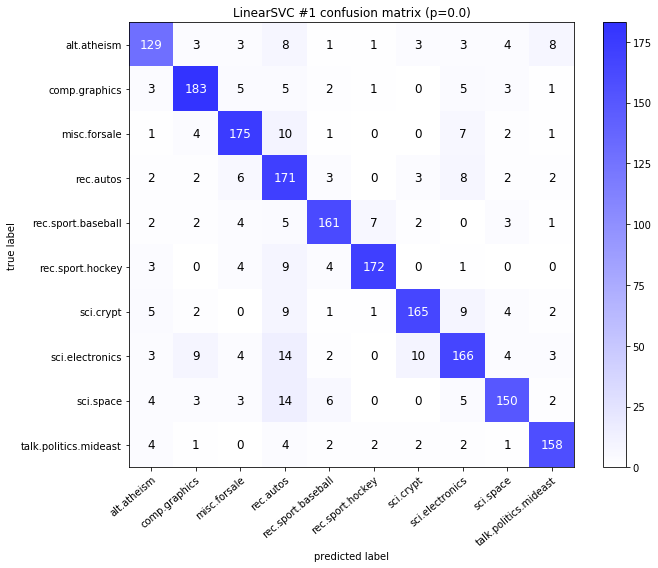

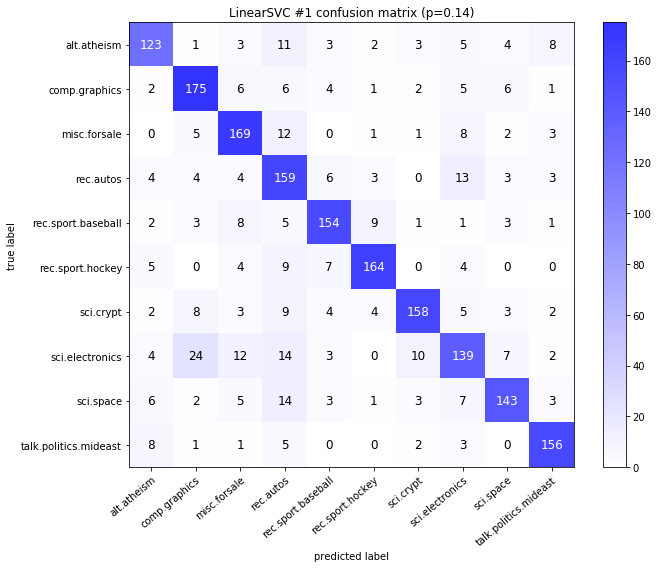

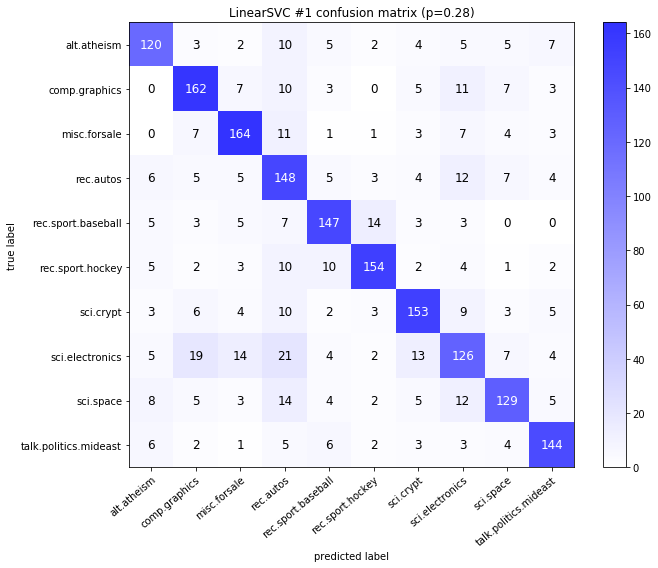

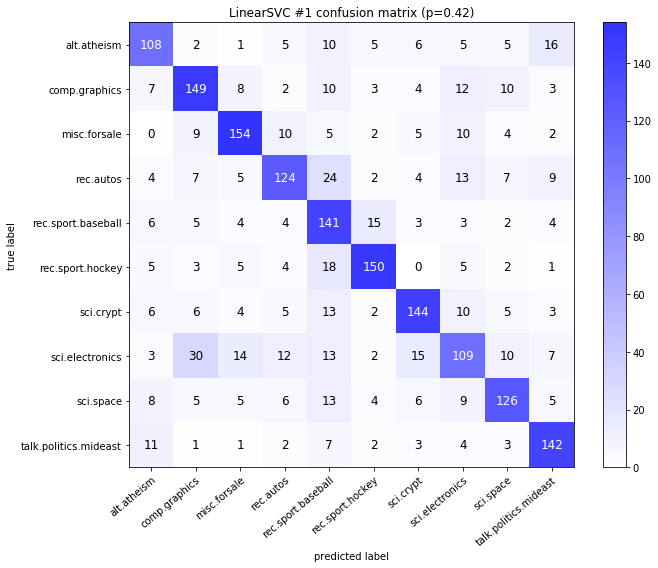

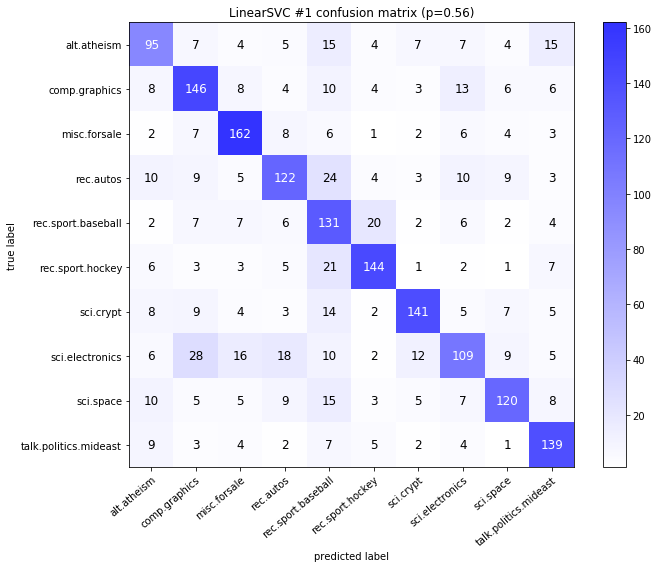

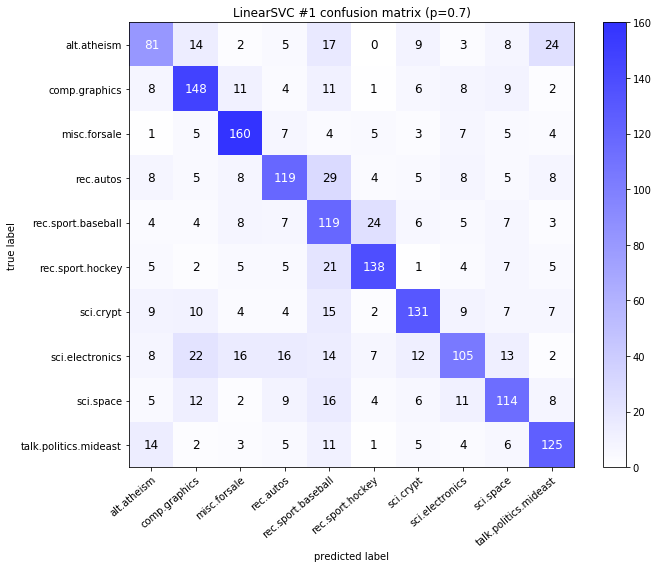

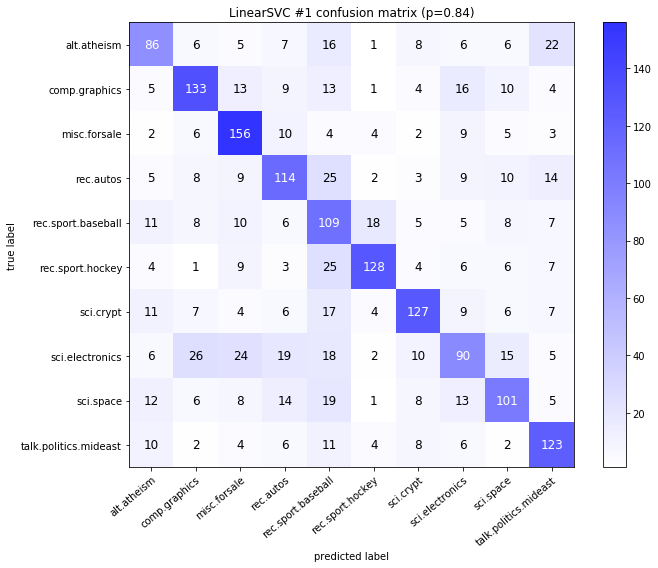

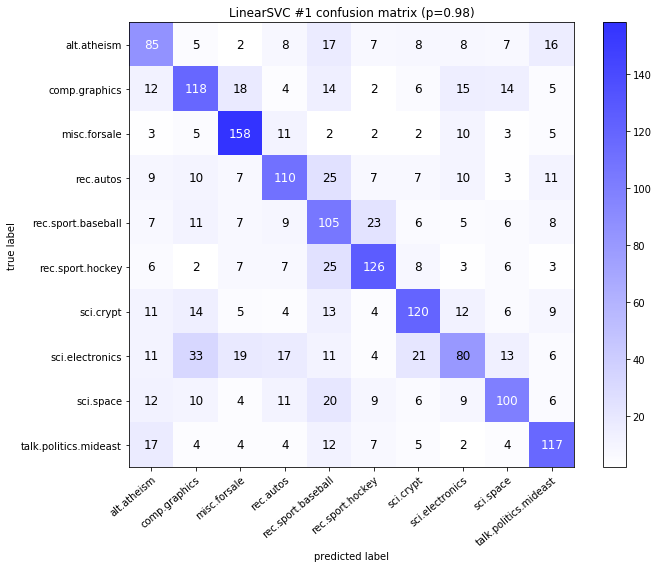

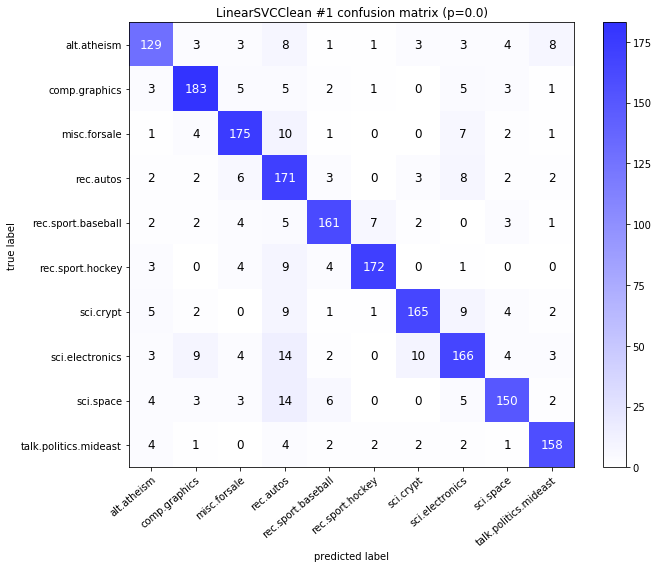

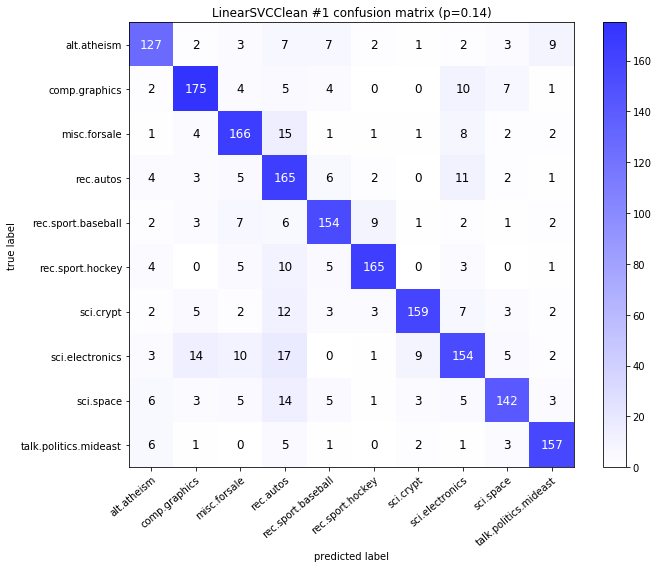

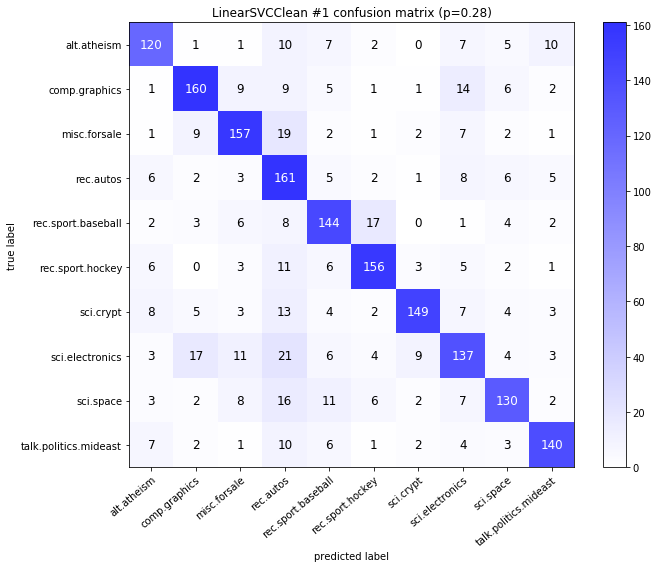

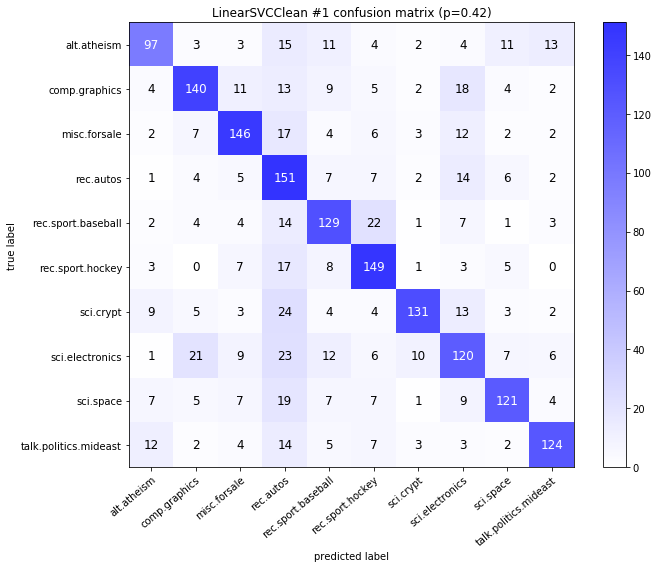

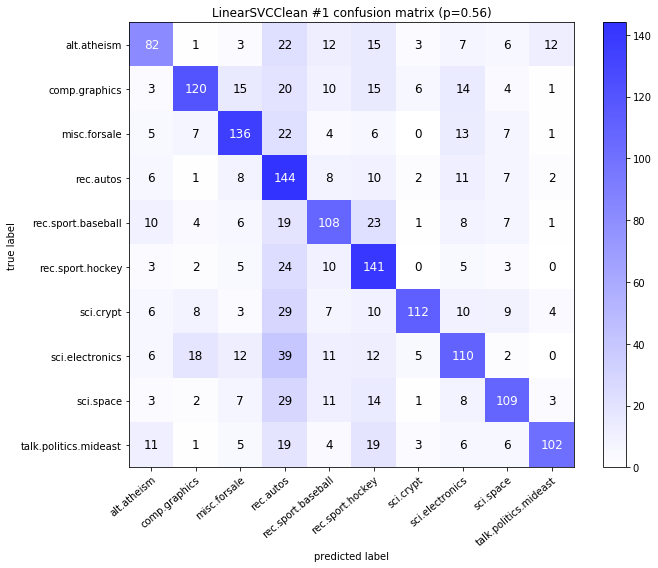

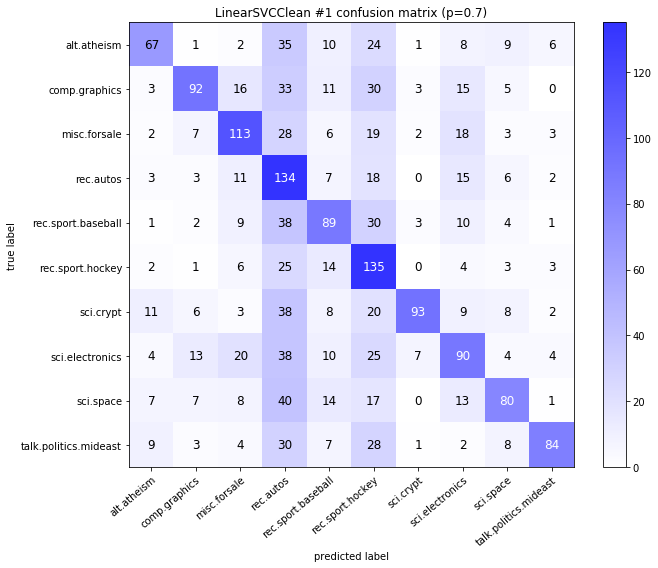

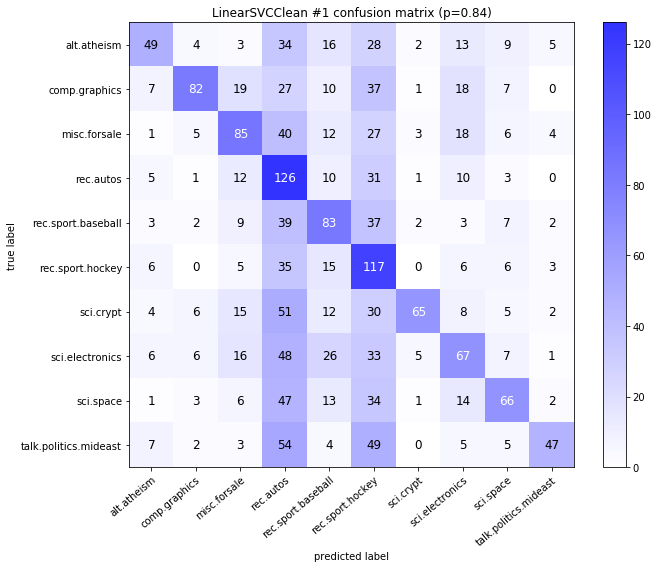

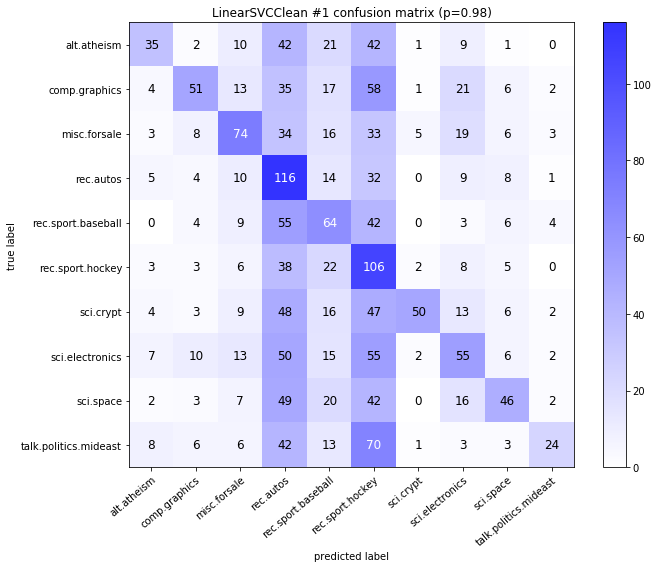

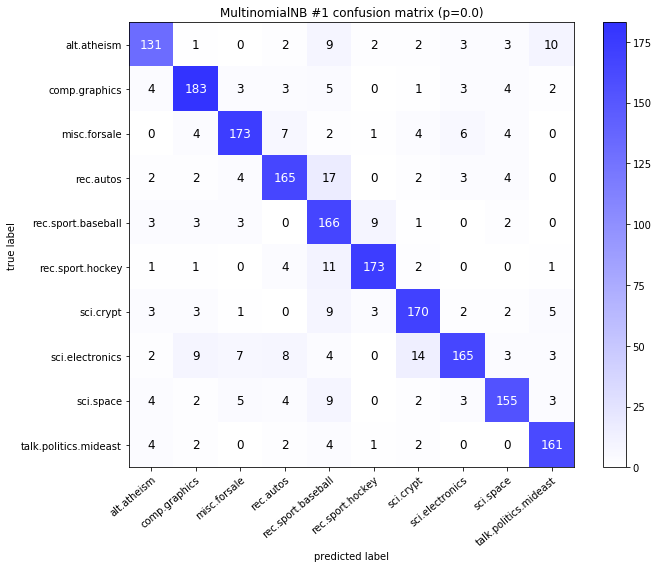

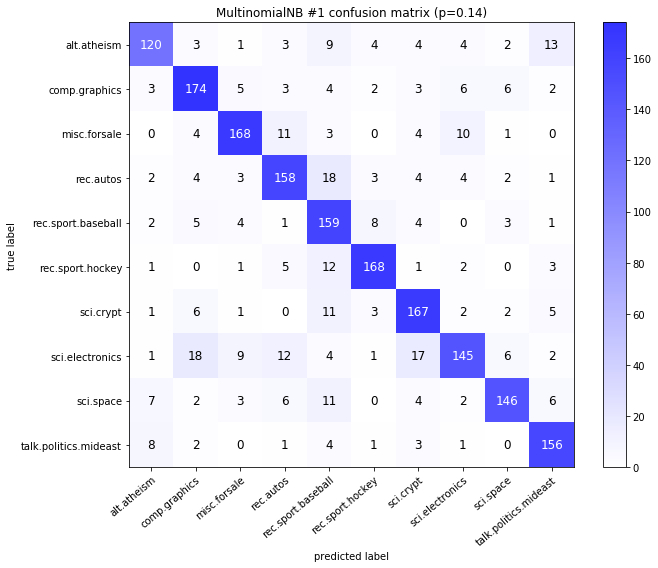

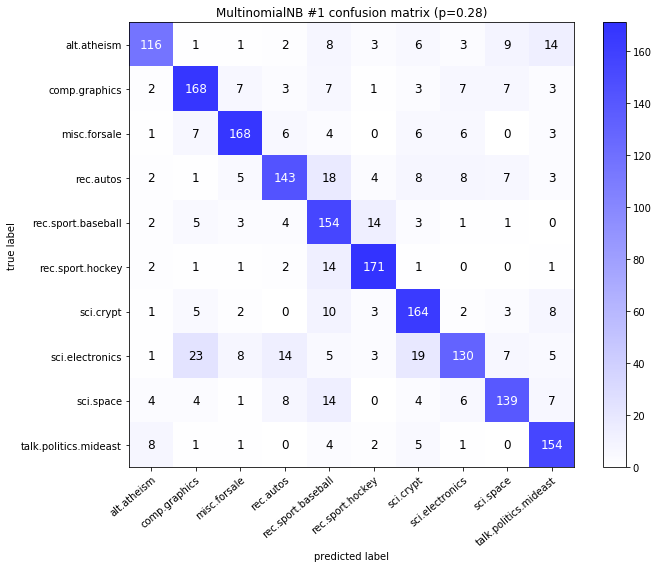

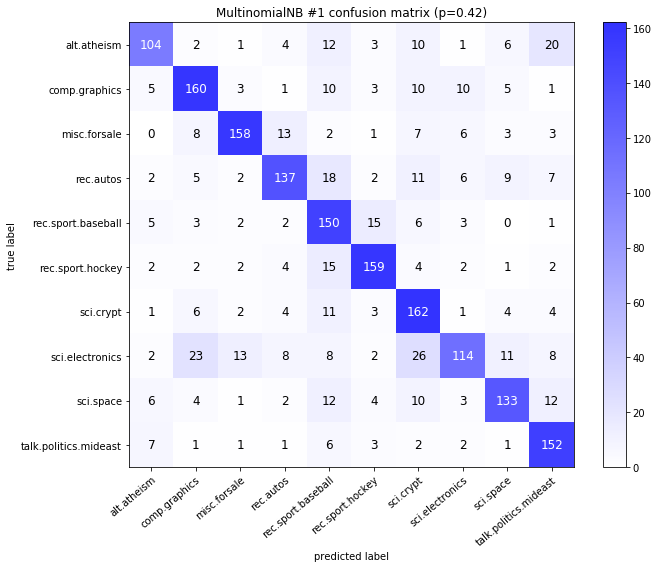

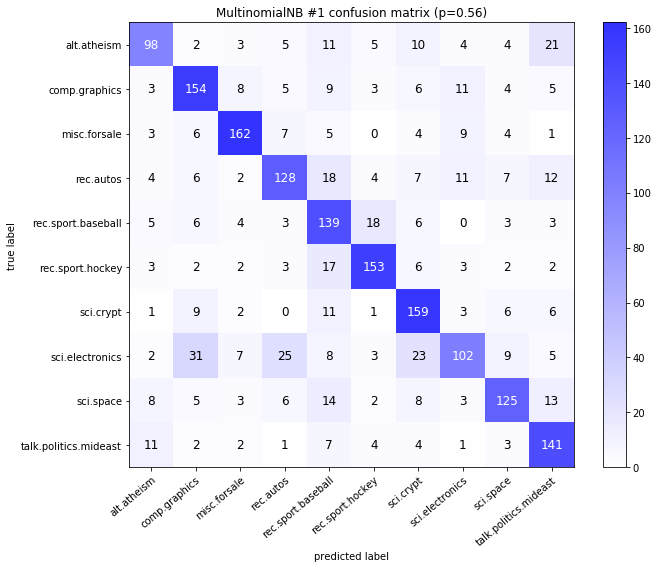

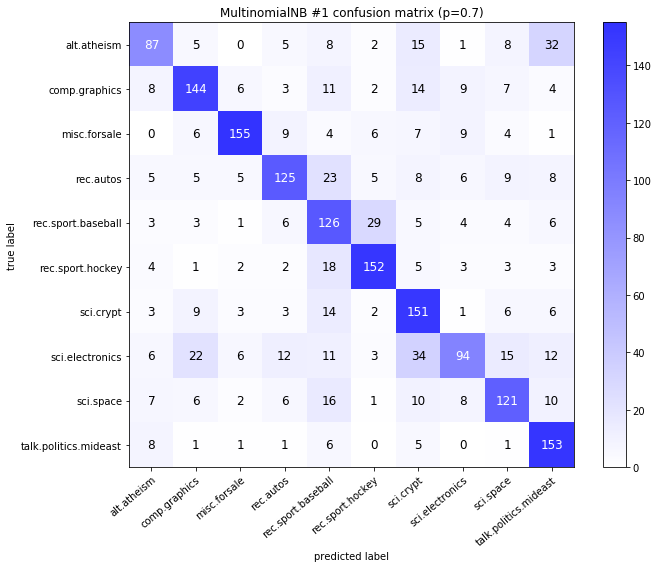

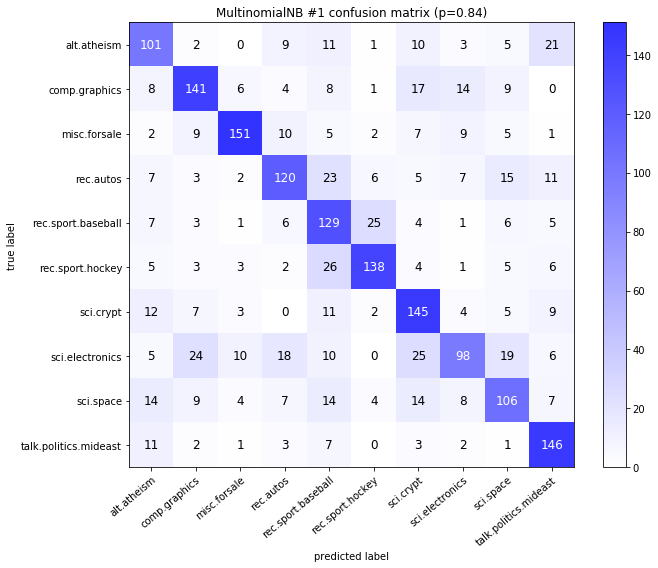

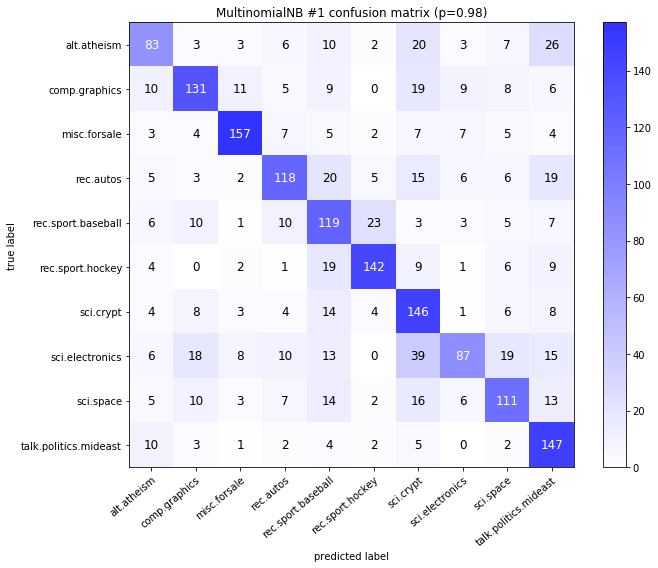

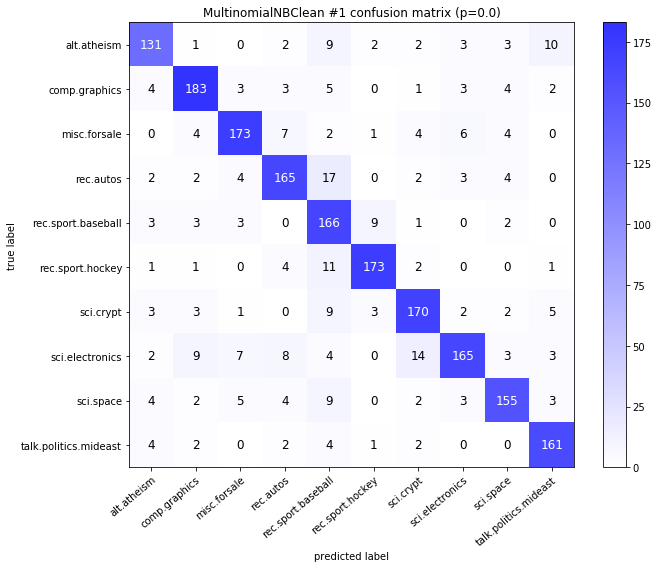

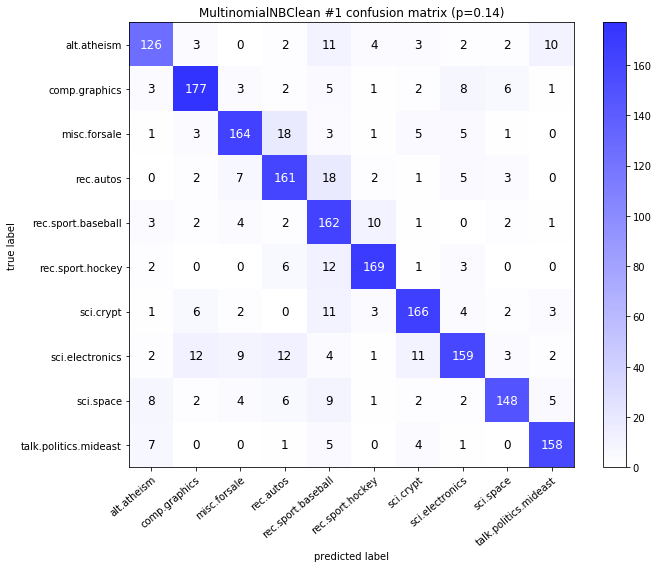

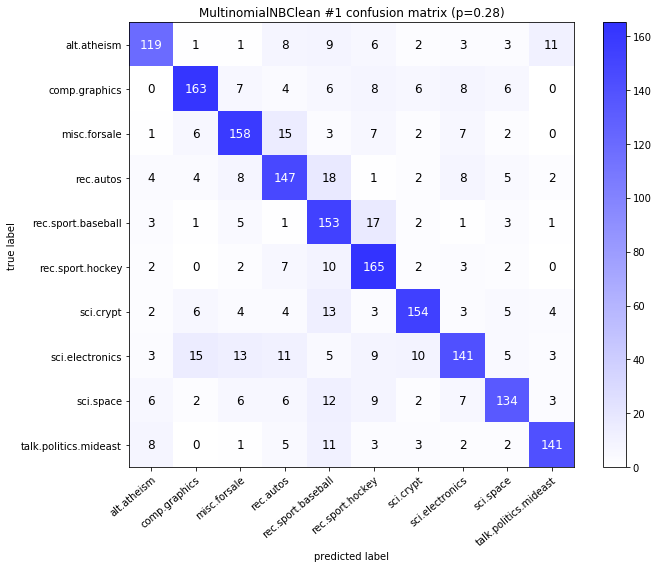

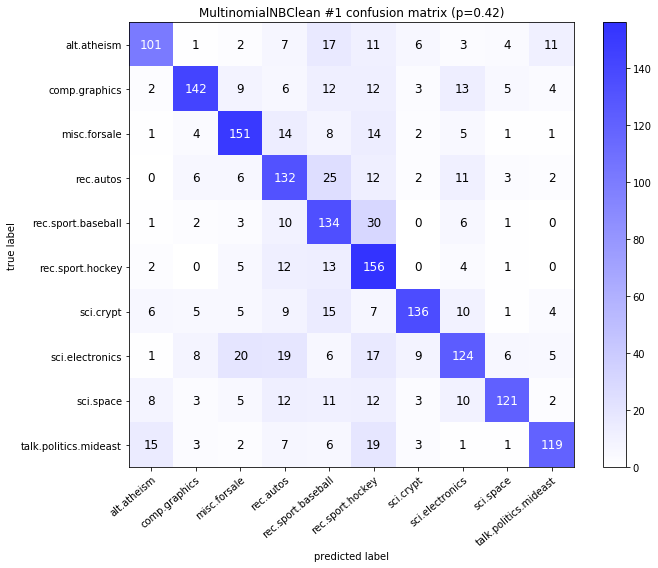

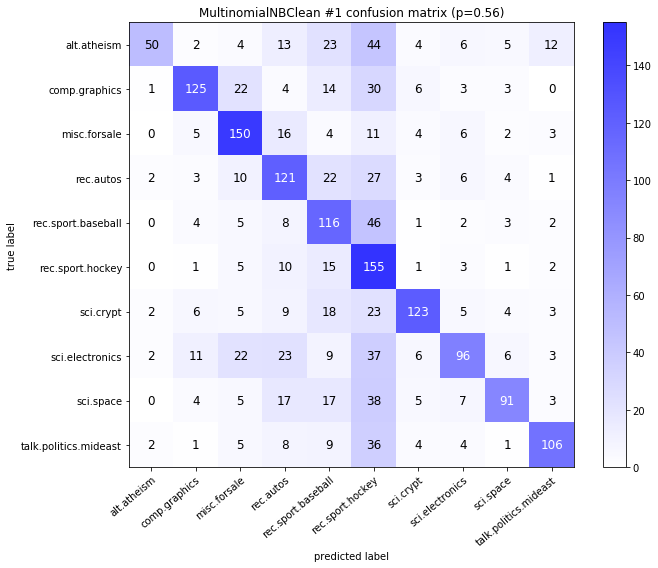

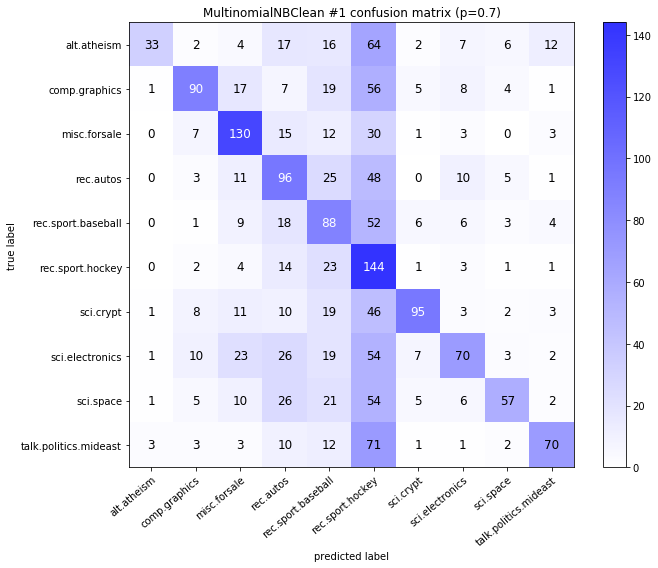

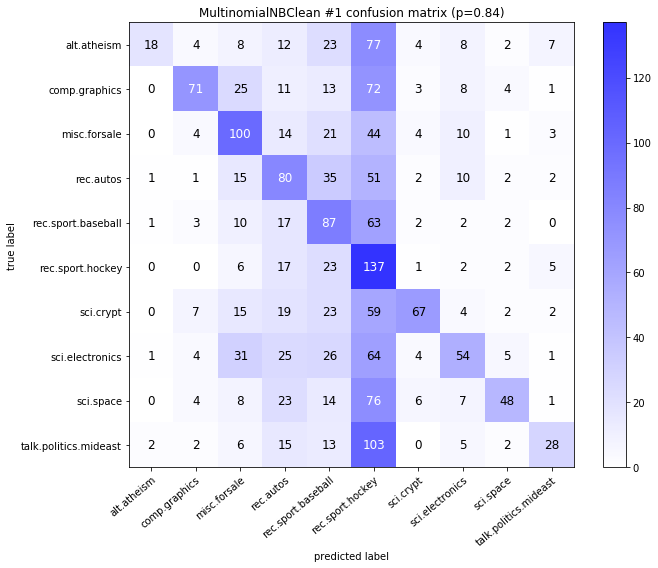

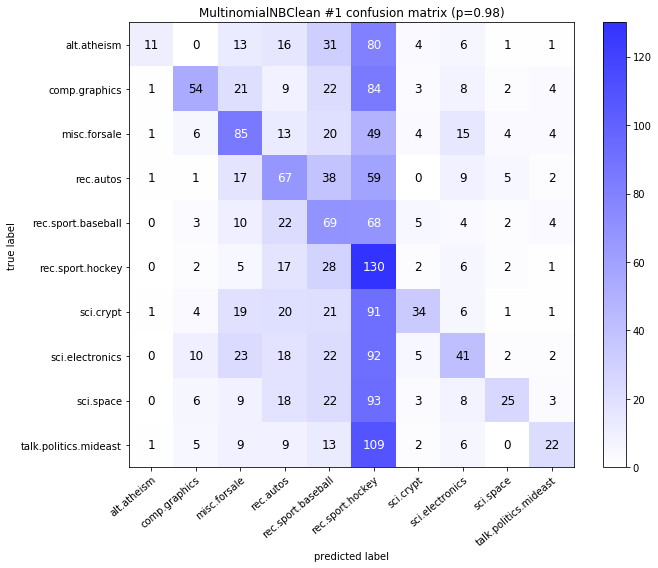

In [10]:
main()

The notebook for this case study can be found [here](https://github.com/dpEmu/dpEmu/blob/master/docs/case_studies/Text_Classification_OCR_Error.ipynb).